In [15]:
import pandas as pd
import numpy as np
import plotly.express as px
import random
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from sklearn.model_selection import GridSearchCV
import shap

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', 150)


In [16]:
file_path = 'data/labeled_df.csv'
df = pd.read_csv(file_path, index_col=0)

In [17]:
df.set_index('client_id', inplace=True)

In [18]:
df.head()

,avg_frequency,std_frequency,max_frequency,count_sales_day,last_purchase,sum_sales,avg_sales,count_sales,unique_product,unique_branch,time_since_last_order,avg_frequency_3m,std_frequency_3m,max_frequency_3m,count_sales_day_3m,sum_sales_3m,avg_sales_3m,count_sales_3m,unique_product_3m,unique_branch_3m,1_month_diff,3_month_diff,6_month_diff,avg_sales_day,avg_sales_day_3m,churn
client_id,,,,,,,,,,,,,,,,,,,,,,,,,,
481,14.000000,21.560546,63.0,9,2019-05-23,3415.987600,83.316771,41,28,3,31,3.750000,3.201562,7.0,5.0,996.352732,33.211758,30.0,18.0,2.0,996.352732,-442.311252,1454.045832,379.554178,199.270546,0.0
485,3.093567,4.324012,45.0,172,2019-06-21,42329.103729,40.818808,1037,355,2,2,2.588235,2.829687,15.0,35.0,7980.027766,49.259431,162.0,99.0,2.0,-2111.759400,-1037.892834,208.338011,246.099440,228.000793,0.0
929,1.000000,0.000000,1.0,4,2019-01-18,1412.293527,36.212655,39,33,1,156,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,353.073382,NaN,1.0
1118,37.857143,72.470532,286.0,15,2019-06-17,6304.106537,106.849263,59,42,1,6,19.500000,9.192388,26.0,3.0,721.797040,120.299507,6.0,6.0,1.0,246.322640,515.731453,927.862627,420.273769,240.599013,0.0
1545,148.000000,220.245318,402.0,4,2019-06-17,1662.666189,92.370344,18,10,1,6,32.000000,NaN,32.0,2.0,467.964309,58.495539,8.0,6.0,1.0,-378.264309,467.964309,467.964309,415.666547,233.982154,1.0


## Drop useless cols

In [19]:
df = df.drop(columns=['last_purchase'])

## EDA

In [20]:
numerical_columns = df.select_dtypes(include=['number']).columns.tolist()

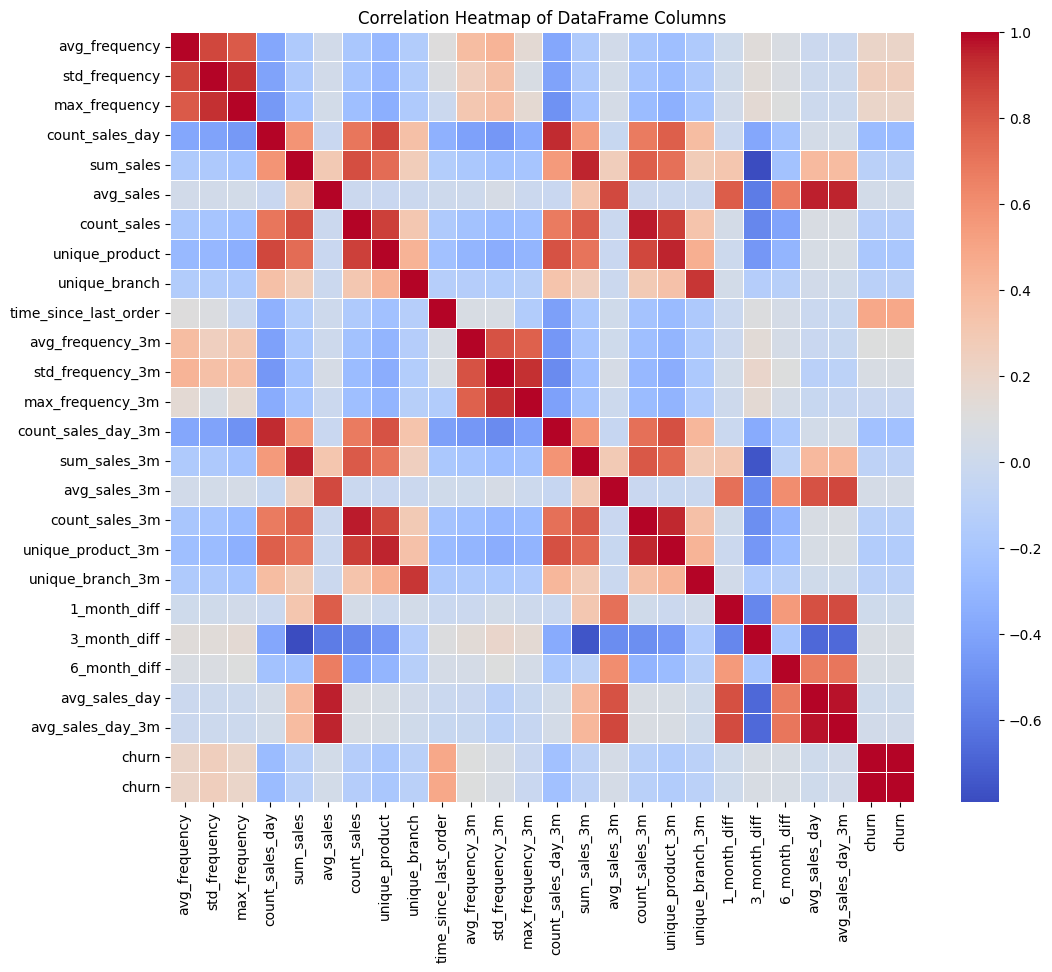

In [21]:
# Compute the correlation matrix
corr = df[numerical_columns + ['churn']].corr()

# Create the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap of DataFrame Columns')
plt.show()

## Try models

In [22]:
df = df.fillna(0)

In [23]:
#df = df.drop(columns=['avg_sales_day', 'avg_sales_day_3m'])

In [24]:
df.describe()

,avg_frequency,std_frequency,max_frequency,count_sales_day,sum_sales,avg_sales,count_sales,unique_product,unique_branch,time_since_last_order,avg_frequency_3m,std_frequency_3m,max_frequency_3m,count_sales_day_3m,sum_sales_3m,avg_sales_3m,count_sales_3m,unique_product_3m,unique_branch_3m,1_month_diff,3_month_diff,6_month_diff,avg_sales_day,avg_sales_day_3m,churn
count,6383.000000,6383.000000,6383.000000,6383.000000,6.383000e+03,6383.000000,6383.000000,6383.000000,6383.000000,6383.000000,6383.000000,6383.000000,6383.000000,6383.000000,6.383000e+03,6383.000000,6383.000000,6383.000000,6383.000000,6383.000000,6.383000e+03,6.383000e+03,6383.000000,6383.000000,6383.000000
mean,35.900957,32.749700,96.965533,44.450572,5.309449e+04,179.728136,352.931224,155.236409,2.585775,77.115620,7.853143,4.710107,15.261476,7.001567,8.319148e+03,139.853422,54.579508,34.812314,1.214163,478.232074,-4.603123e+03,-4.434805e+03,882.505878,647.212149,0.256619
std,45.910835,39.872359,80.564878,67.698138,2.074377e+05,617.840689,1212.717823,336.150460,5.017687,110.632378,12.862911,7.989242,18.749928,11.562916,3.374058e+04,537.256579,191.873832,93.865601,1.915246,12265.078044,2.774845e+04,4.955079e+04,5630.796947,5280.057873,0.436802
min,0.000000,0.000000,0.000000,1.000000,-7.676301e+01,-1.524018,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.654599e+02,-1.723540,0.000000,0.000000,0.000000,-205444.017798,-1.383604e+06,-1.590752e+06,-12.793835,-18.384431,0.000000
25%,7.624094,7.066598,36.000000,6.000000,2.324764e+03,71.209016,22.000000,16.000000,1.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,-211.835589,-2.700710e+03,-4.196156e+03,272.418726,0.000000,0.000000
50%,20.136364,19.629909,75.000000,16.000000,8.374202e+03,111.413388,68.000000,47.000000,2.000000,23.000000,2.750000,0.000000,7.000000,2.000000,7.180692e+02,70.058721,7.000000,6.000000,1.000000,146.197200,-1.366931e+02,-3.590797e+02,499.317302,256.755933,0.000000
75%,45.000000,43.727311,136.000000,49.000000,3.313615e+04,186.395696,241.000000,147.500000,3.000000,103.000000,10.428571,6.777719,26.000000,8.000000,4.607452e+03,149.737899,35.000000,28.000000,1.000000,796.448462,3.973208e+02,6.298691e+02,890.455559,667.508580,1.000000
max,511.000000,366.988419,526.000000,409.000000,8.508021e+06,44988.294824,47832.000000,5127.000000,248.000000,536.000000,87.000000,60.104076,87.000000,71.000000,1.192973e+06,33901.580323,6117.000000,1553.000000,70.000000,813637.927748,1.386434e+05,2.946204e+06,437613.413289,406818.963874,1.000000


In [25]:
# Define features (X) and target variable (y)
X = df.drop(columns=['churn'])
y = df['churn']

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
def train_and_evaluate_model(X, y, model):
    # Define numerical and categorical features
    numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
    categorical_features = X.select_dtypes(include=['object']).columns

    # Create preprocessing pipeline
    numerical_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    # Create pipeline with preprocessing and the given model
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    # Perform train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:, 1]

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)

    # Calculate AUC
    auc_score = roc_auc_score(y_test, y_prob)
    print("AUC Score:", auc_score)

    # Calculate recall
    recall = recall_score(y_test, y_pred)
    print("Recall:", recall)

    # Calculate F1 score
    f1 = f1_score(y_test, y_pred)
    print("F1 Score:", f1)

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4, 2))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Plot ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(4, 2))
    plt.plot(fpr, tpr, lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()
    
    return 'done'

Accuracy: 0.8332028191072827
AUC Score: 0.8772682519504473
Recall: 0.5784883720930233
F1 Score: 0.6513911620294599


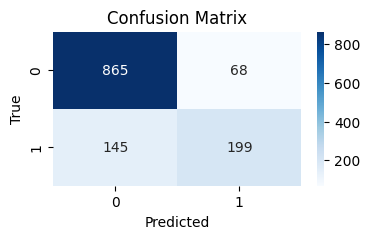

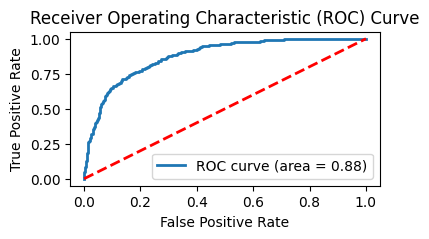

'done'

In [28]:
train_and_evaluate_model(X, y, model=LogisticRegression(random_state=42))

Accuracy: 0.7666405638214565
AUC Score: 0.8781468880081755
Recall: 0.8430232558139535
F1 Score: 0.6605922551252847


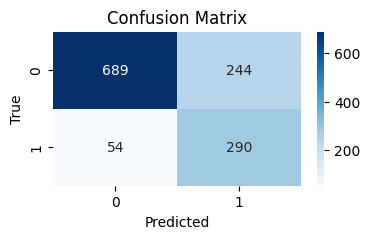

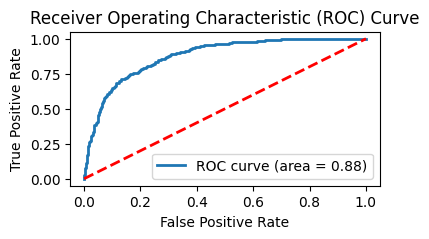

'done'

In [29]:
train_and_evaluate_model(X, y, model=LogisticRegression(class_weight='balanced', random_state=42))

Accuracy: 0.8261550509005482
AUC Score: 0.889207731997308
Recall: 0.6133720930232558
F1 Score: 0.65527950310559


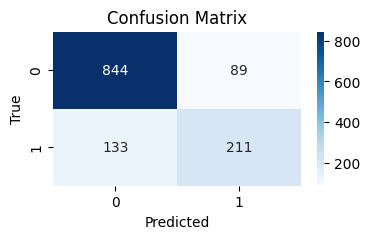

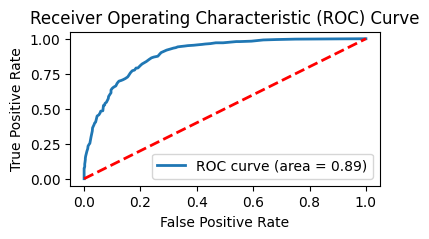

'done'

In [30]:
train_and_evaluate_model(X, y, model=RandomForestClassifier(random_state=42))

Accuracy: 0.8253719655442443
AUC Score: 0.8933890425982702
Recall: 0.5930232558139535
F1 Score: 0.6465927099841522


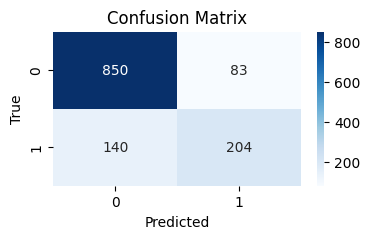

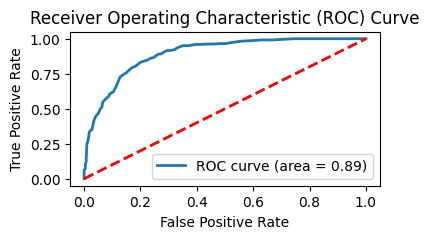

'done'

In [31]:
train_and_evaluate_model(X, y, model=RandomForestClassifier(class_weight='balanced', random_state=42))

Accuracy: 0.826938136256852
AUC Score: 0.8823032727635285
Recall: 0.6191860465116279
F1 Score: 0.6584234930448223


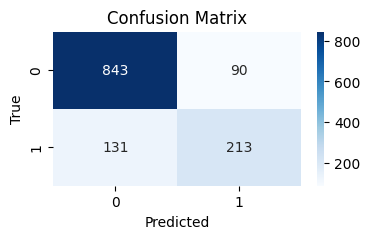

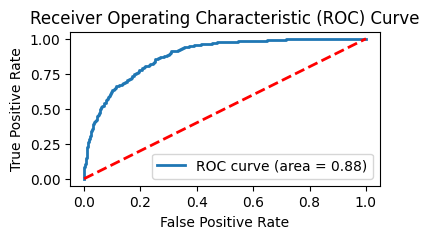

'done'

In [32]:
train_and_evaluate_model(X, y, model=xgb.XGBClassifier(random_state=42))

Accuracy: 0.8198903680501175
AUC Score: 0.8867930407039057
Recall: 0.7209302325581395
F1 Score: 0.6831955922865014


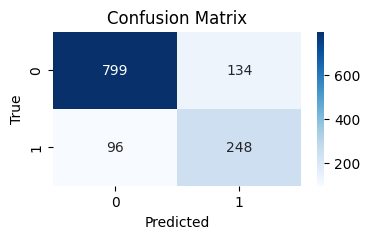

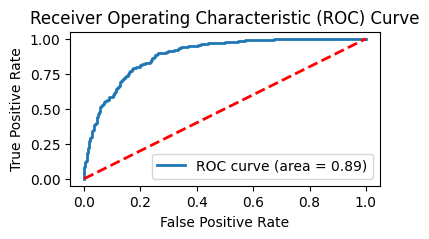

'done'

In [33]:
train_and_evaluate_model(X, y, model=xgb.XGBClassifier(random_state=42, scale_pos_weight=sum(y_train == 0) / sum(y_train == 1)))

## Tune model

In [34]:
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__max_depth': [3, 4, 5],
}

xgb_model = xgb.XGBClassifier(scale_pos_weight=sum(y_train == False) / sum(y_train == True))

numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Create preprocessing pipeline
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb_model)
])

# Perform grid search
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='f1', cv=5)

grid_search.fit(X_train, y_train)

# Get the best parameters and best F1 score
best_params = grid_search.best_params_
best_f1_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best F1 Score:", best_f1_score)


Best Parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 200}
Best F1 Score: 0.6754261266575083


## Interprete model

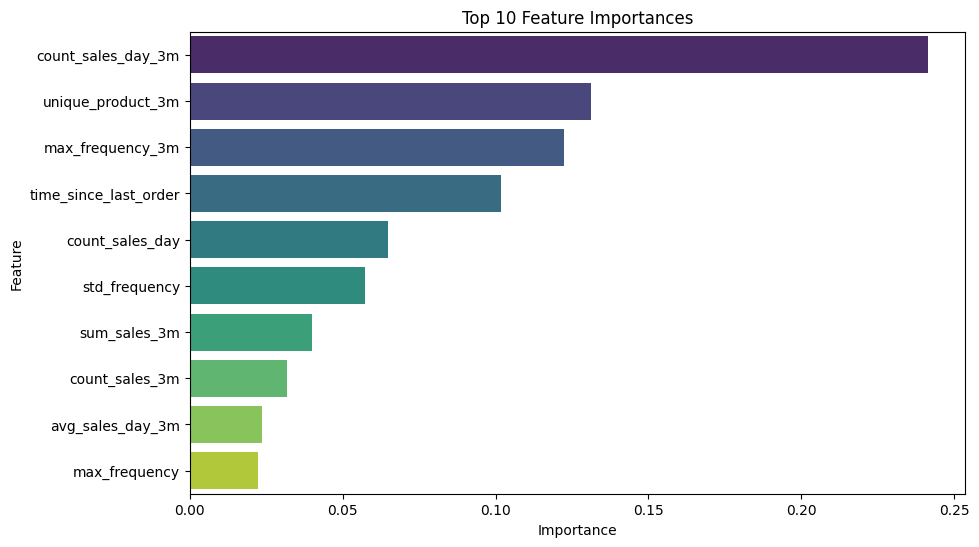

In [35]:
# Get the one-hot encoded feature names from the preprocessor
#onehot_columns = grid_search.best_estimator_.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(input_features=categorical_features)

# Combine numerical and one-hot encoded feature names
transformed_feature_names = list(numerical_features)

# Get feature importances
feature_importances = grid_search.best_estimator_.named_steps['classifier'].feature_importances_

# Create a DataFrame to display feature importances
importance_df = pd.DataFrame({'Feature': transformed_feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df[:10], palette='viridis')
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


 96%|=================== | 4902/5106 [00:12<00:00]       

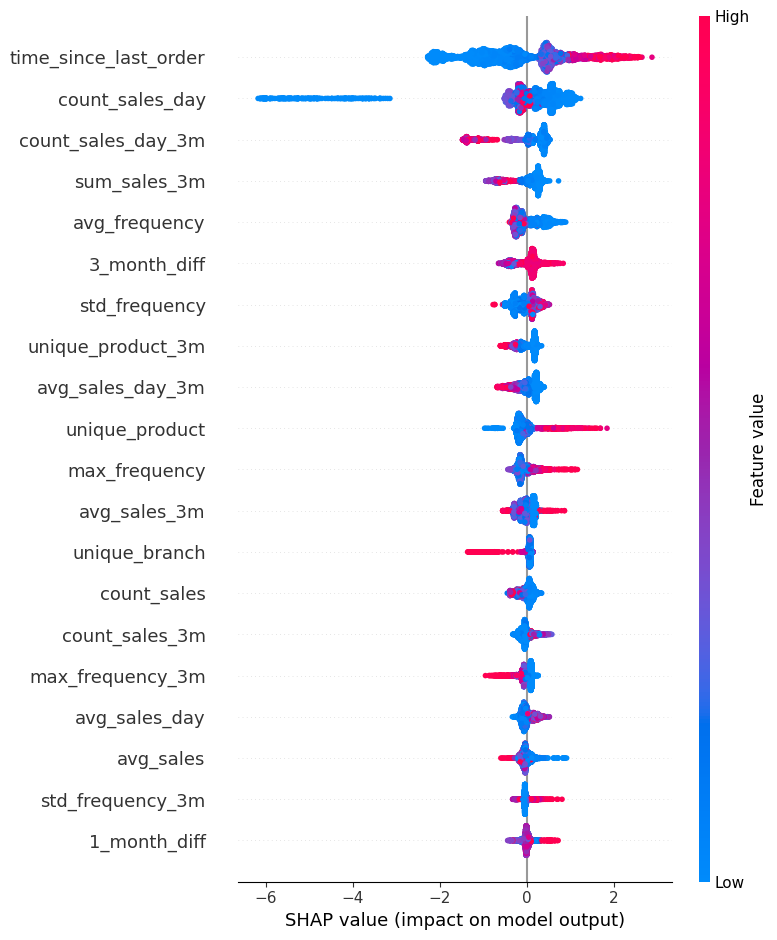

In [36]:
# Get the preprocessed data
X_train_transformed = grid_search.best_estimator_.named_steps['preprocessor'].transform(X_train)

# Initialize the XGBoost model (without scale_pos_weight as it's not supported in SHAP)
xgb_model = grid_search.best_estimator_.named_steps['classifier']

# Create a SHAP explainer object
explainer = shap.Explainer(xgb_model, X_train_transformed)

# Calculate Shapley values
shap_values = explainer.shap_values(X_train_transformed)

# Summary plot
shap.summary_plot(shap_values, X_train_transformed, feature_names=transformed_feature_names)


## Extract model output

In [37]:
model = xgb.XGBClassifier(scale_pos_weight=sum(y_train == False) / sum(y_train == True), learning_rate= 0.1, max_depth=3, n_estimators=200)

Accuracy: 0.7948316366483946
AUC Score: 0.8983555173359256
Recall: 0.8517441860465116
F1 Score: 0.6910377358490566


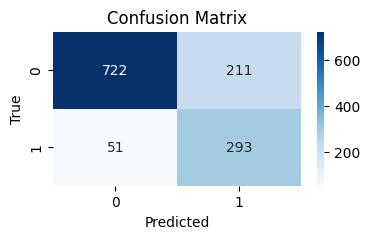

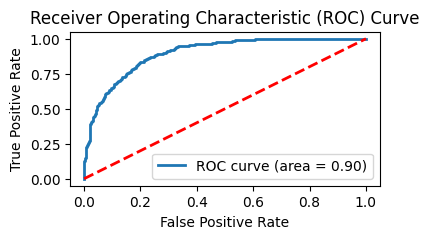

In [39]:

# Define numerical and categorical features
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Create preprocessing pipeline
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create pipeline with preprocessing and the given model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
y_prob = pipeline.predict_proba(X_test)[:, 1]

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate AUC
auc_score = roc_auc_score(y_test, y_prob)
print("AUC Score:", auc_score)

# Calculate recall
recall = recall_score(y_test, y_pred)
print("Recall:", recall)

# Calculate F1 score
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 2))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(4, 2))
plt.plot(fpr, tpr, lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [40]:
pred_dataset = X_test.copy()
pred_dataset['y_prob'] = y_prob
pred_dataset['y_pred'] = y_pred

#### Tableau extract

In [41]:
pred_dataset.reset_index(inplace=True)

In [42]:
pred_dataset.sort_values(by='y_prob', inplace=True)

In [43]:
pred_dataset.describe()

,client_id,avg_frequency,std_frequency,max_frequency,count_sales_day,sum_sales,avg_sales,count_sales,unique_product,unique_branch,time_since_last_order,avg_frequency_3m,std_frequency_3m,max_frequency_3m,count_sales_day_3m,sum_sales_3m,avg_sales_3m,count_sales_3m,unique_product_3m,unique_branch_3m,1_month_diff,3_month_diff,6_month_diff,avg_sales_day,avg_sales_day_3m,y_prob,y_pred
count,1.277000e+03,1277.000000,1277.000000,1277.000000,1277.000000,1.277000e+03,1277.000000,1277.000000,1277.000000,1277.000000,1277.000000,1277.000000,1277.000000,1277.000000,1277.000000,1277.000000,1277.000000,1277.000000,1277.000000,1277.00000,1277.000000,1277.000000,1277.000000,1277.000000,1277.000000,1277.000000,1277.000000
mean,1.113589e+06,36.497740,33.192419,99.516836,44.035239,5.124166e+04,181.427145,336.454190,148.889585,2.494910,78.324980,8.498512,4.648121,15.779170,6.787784,8072.386271,126.120300,52.169146,33.318716,1.19029,174.949138,-4117.446643,-4321.330122,867.222667,597.366091,0.371505,0.394675
std,6.657780e+05,49.318498,40.465680,83.454561,67.480889,1.837463e+05,333.605746,984.456202,317.050844,2.577212,111.910112,13.964233,7.914517,19.236316,11.498790,31578.346915,224.094931,171.002625,94.138418,1.37737,6565.304064,22203.131587,26275.575802,1979.722148,2033.091049,0.341006,0.488972
min,3.257000e+03,0.000000,0.000000,0.000000,1.000000,-4.572055e+01,-1.524018,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-17.112000,-1.426000,0.000000,0.000000,0.00000,-71465.032403,-496174.820623,-563350.692784,-9.144110,-17.112000,0.000221,0.000000
25%,5.327660e+05,7.746269,7.402320,39.000000,6.000000,2.278546e+03,72.334907,21.000000,16.000000,1.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,-257.996520,-2440.882949,-4409.012887,269.173266,0.000000,0.016474,0.000000
50%,1.121474e+06,20.500000,19.514286,77.000000,15.000000,8.368230e+03,111.130012,65.000000,45.000000,2.000000,24.000000,2.774194,0.000000,7.000000,2.000000,643.659600,70.738422,7.000000,6.000000,1.00000,127.513840,-128.251036,-385.934749,487.334020,259.393303,0.303393,0.000000
75%,1.697728e+06,45.500000,42.551353,140.000000,48.000000,3.357051e+04,187.468008,248.000000,149.000000,3.000000,102.000000,11.000000,7.071068,28.000000,7.000000,4423.521000,147.989360,31.000000,25.000000,2.00000,727.464921,445.763285,618.353344,885.716928,617.464532,0.677983,1.000000
max,2.273424e+06,511.000000,366.988419,526.000000,409.000000,4.610239e+06,5562.145200,16143.000000,4879.000000,32.000000,513.000000,85.000000,55.861436,85.000000,71.000000,703339.110229,4190.255613,2879.000000,1553.000000,15.00000,68919.143193,138643.357453,241268.042070,37500.434595,52995.869819,0.997006,1.000000


In [ ]:
# 10 client > 0.9

# 10 clients < 0.2

# 10 client entre 0.6 et 0.8

In [54]:

# Filter the dataset based on the conditions
selected_data = pred_dataset[(pred_dataset['y_prob'] > 0.9) & (pred_dataset['client_id'].isin(pred_dataset.nlargest(5, 'y_prob')['client_id'])) |
                             (pred_dataset['y_prob'] < 0.5) & (pred_dataset['client_id'].isin(pred_dataset.nsmallest(5, 'y_prob')['client_id'])) |
                             ((pred_dataset['y_prob'] >= 0.6) & (pred_dataset['y_prob'] <= 0.8)) & (pred_dataset['client_id'].isin(pred_dataset[(pred_dataset['y_prob'] >= 0.6) & (pred_dataset['y_prob'] <= 0.8)]['client_id'].head(10))) |
                             ((pred_dataset['y_prob'] >= 0.6) & (pred_dataset['y_prob'] <= 0.8)) & (pred_dataset['client_id'].isin(pred_dataset[(pred_dataset['y_prob'] >= 0.7) & (pred_dataset['y_prob'] <= 0.8)]['client_id'].head(10)))]


In [55]:
selected_data

,client_id,avg_frequency,std_frequency,max_frequency,count_sales_day,sum_sales,avg_sales,count_sales,unique_product,unique_branch,time_since_last_order,avg_frequency_3m,std_frequency_3m,max_frequency_3m,count_sales_day_3m,sum_sales_3m,avg_sales_3m,count_sales_3m,unique_product_3m,unique_branch_3m,1_month_diff,3_month_diff,6_month_diff,avg_sales_day,avg_sales_day_3m,y_prob,y_pred
648,635947,5.438776,5.889124,38.0,99,54786.210816,105.764886,518,335,7,2,5.117647,3.871084,15.0,18.0,4863.063451,91.755914,53.0,47.0,4.0,-1112.567347,-4471.504244,-19072.518276,553.396069,270.170192,0.000221,0
387,664915,3.503268,2.643573,13.0,154,93588.854753,80.680047,1160,550,9,2,3.346154,2.208027,8.0,27.0,15708.689868,77.003382,204.0,153.0,4.0,-786.932319,-3748.961898,-19861.405879,607.719836,581.803328,0.000250,0
1257,810079,2.481481,2.302603,21.0,217,127788.267220,100.699974,1269,754,8,2,2.866667,3.954337,21.0,31.0,17360.046690,99.200267,175.0,137.0,4.0,7071.903488,-4473.868770,-12764.677441,588.886024,560.001506,0.000251,0
444,553352,4.196850,5.498974,45.0,128,268355.042901,114.242249,2349,538,10,2,2.636364,1.997157,9.0,34.0,82075.817013,94.340020,870.0,344.0,4.0,-8274.615344,-69542.248993,43980.782803,2096.523773,2413.994618,0.000268,0
502,1021065,2.317391,1.980065,14.0,231,285275.038023,127.014710,2246,1094,7,2,2.378378,2.628385,14.0,38.0,46541.572035,140.608979,331.0,217.0,3.0,-2838.741463,-46683.608070,-15855.149065,1234.956875,1224.778211,0.000305,0
976,1916716,20.045455,19.514286,78.0,23,2650.422479,29.780028,89,32,2,96,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,58.565820,-32.856113,-74.118113,115.235760,0.000000,0.600311,1
1098,1356026,25.266667,26.942973,91.0,16,12703.846419,132.331734,96,42,1,152,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,3831.683819,-192.363981,3440.973619,793.990401,0.000000,0.601578,1
550,1768873,55.833333,41.700919,125.0,7,248.347560,24.834756,10,1,2,174,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,-99.339024,0.000000,35.478223,0.000000,0.602659,1
800,1565275,35.600000,38.916435,118.0,11,40366.512816,357.225777,113,92,3,159,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,-793.282688,4051.663202,-10933.962194,3669.682983,0.000000,0.603012,1
290,1716358,53.111111,69.736010,189.0,10,2455.156528,76.723641,32,21,2,52,0.000000,0.000000,0.0,1.0,25.753560,6.438390,4.0,3.0,1.0,25.753560,25.753560,-721.437320,245.515653,25.753560,0.604960,1


In [56]:
selected_data.to_csv('tableau_churn_pred_v2.csv')

In [57]:
tableau_clients_list = list(selected_data['client_id'])

In [58]:
tableau_clients_list

[635947,
 664915,
 810079,
 553352,
 1021065,
 1916716,
 1356026,
 1768873,
 1565275,
 1716358,
 1616453,
 481761,
 497678,
 1433150,
 2034034,
 1307717,
 588583,
 1356572,
 302560,
 2219247,
 1746783,
 861310,
 537405,
 1114485,
 1190353,
 53606,
 977201,
 1199790,
 1448824,
 366373]

#### Predictions for the future

In [59]:
file_path = 'data/data_for_pred.csv'
df = pd.read_csv(file_path, index_col=0)

df.set_index('client_id', inplace=True)
df = df.drop(columns=['last_purchase'])
df = df.fillna(0)

In [62]:
df.head()

,avg_frequency,std_frequency,max_frequency,count_sales_day,sum_sales,avg_sales,count_sales,unique_product,unique_branch,time_since_last_order,avg_frequency_3m,std_frequency_3m,max_frequency_3m,count_sales_day_3m,sum_sales_3m,avg_sales_3m,count_sales_3m,unique_product_3m,unique_branch_3m,1_month_diff,3_month_diff,6_month_diff,avg_sales_day,avg_sales_day_3m
client_id,,,,,,,,,,,,,,,,,,,,,,,,
14,1.444744,0.963688,10.0,372,2.336735e+06,246.335076,9486,4081,8,2,1.419355,0.878680,5.0,63.0,416183.145177,219.969950,1892.0,1232.0,6.0,-76911.676120,-248130.036525,-94480.806002,6281.544444,6606.081669
211,27.052632,30.152342,111.0,20,5.979514e+03,91.992523,65,56,9,10,9.250000,5.619905,15.0,5.0,847.283200,65.175631,13.0,11.0,3.0,-842.260000,439.442232,554.774015,298.975701,169.456640
549,3.573333,2.525964,12.0,151,9.841328e+04,116.603414,844,408,2,2,4.250000,2.917732,12.0,21.0,14261.630415,108.867408,131.0,88.0,2.0,-2827.211005,-811.045318,-22797.507954,651.743583,679.125258
753,2.476852,1.907006,13.0,217,6.588005e+05,181.437745,3631,1349,5,3,2.097561,1.529786,7.0,42.0,117054.108422,182.043714,643.0,410.0,2.0,-20037.966899,49993.571210,-36839.703677,3035.946785,2787.002581
774,17.307692,17.301489,60.0,27,8.464656e+04,546.106859,155,112,2,37,4.000000,NaN,4.0,2.0,5348.784427,334.299027,16.0,10.0,1.0,5348.784427,-35252.456619,-44259.856587,3135.057896,2674.392214


In [65]:
y_pred = pipeline.predict(df)
y_prob = pipeline.predict_proba(df)[:, 1]

In [66]:
y_pred.sum()

4597

In [67]:
df.shape

(12845, 24)

In [68]:
4597/12845

0.3578824445309459